<a href="https://colab.research.google.com/github/Zoro114/mne/blob/main/decoding_sensor_space_data_with_generalization_across_time_and_conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 4.6 MB/s 


In [3]:
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator


In [5]:
data_path=sample.data_path()
meg_fname=data_path/"MEG"/"sample"
raw_fname=meg_fname/"sample_audvis_filt-0-40_raw.fif"
events_fname=meg_fname/"sample_audvis_filt-0-40_raw-eve.fif"
raw=mne.io.read_raw_fif(raw_fname,preload=True)


Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 875GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [6]:
picks=mne.pick_types(raw.info,meg=True,exclude='bads')
raw.filter(1,30,fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 497 samples (3.310 sec)



<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

In [7]:
events=mne.read_events(events_fname)
event_id={"Auditory/Left":1,"Auditory/Right":2,"Visual/Left":3,"Visual/Right":4}

In [9]:
tmin=-0.05
tmax=0.4
decim=2

In [11]:
epochs=mne.Epochs(raw,events,event_id=event_id,tmin=tmin,tmax=tmax,baseline=None,proj=True,picks=picks,
                  preload=True,reject=dict(mag=5e-12),decim=decim,verbose='error')

In [12]:
clf=make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear')

)

In [13]:
time_gen=GeneralizingEstimator(clf,scoring='roc_auc',n_jobs=1,verbose=True)
time_gen.fit(X=epochs['Left'].get_data(),y=epochs['Left'].events[:,2]>2)

  0%|          | Fitting GeneralizingEstimator : 0/35 [00:00<?,       ?it/s]

<GeneralizingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(solver='liblinear'))]),
           n_jobs=1, scoring='roc_auc', fitted with 35 estimators, fitted with 35 estimators>

In [14]:
scores = time_gen.score(X=epochs['Right'].get_data(),
                        y=epochs['Right'].events[:, 2] > 2)

  0%|          | Scoring GeneralizingEstimator : 0/1225 [00:00<?,       ?it/s]

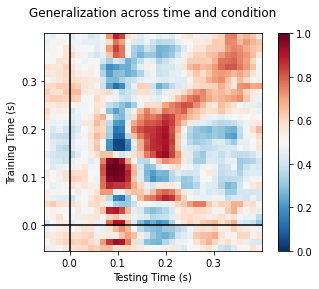

In [16]:
fig, ax = plt.subplots(1)
im = ax.matshow(scores, vmin=0, vmax=1., cmap='RdBu_r', origin='lower',
                extent=epochs.times[[0, -1, 0, -1]])
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Generalization across time and condition')
plt.colorbar(im, ax=ax)